# How would Melbourne look like without covid-19?

## Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import folium
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Motivation

Our goal is to predict the number of pedestrians without COVID. The chosen datasets are therefor:
-	Pedestrian data
-	Weather data (For better prediction)
-	COVID-19 data 

In [2]:
#Pedestrian data
data=pd.read_csv('Pedestrians.csv')
data['Date_Time']=pd.to_datetime(data['Date_Time'], format='%m/%d/%Y %I:%M:%S %p')
data=data.drop('Unnamed: 0',axis=1)

#Weather data
weather_df=pd.read_csv('WeatherData.csv')
weather_df.drop('Unnamed: 0',axis='columns', inplace=True)
weather_df['Date_Time']=pd.to_datetime(weather_df['Date_Time'],format='%Y-%m-%d')

weather_df=weather_df.loc[weather_df['Date_Time']>=data['Date_Time'].min()]
weather_df=weather_df.loc[weather_df['Date_Time']<=data['Date_Time'].max()]

#Covid cases in AUS
covid_data=pd.read_csv('covid_data.csv')
covid_data=covid_data.drop('Unnamed: 0',axis=1)
covid_data['Date_Time']=pd.to_datetime(covid_data['date'],format='%Y-%m-%d')

# Basic Stats

The catagorical data is onehot encoded and the data is divided into before and after COVID-19.
Futhermore the weather and pedestrian data is  merged.

### Preprocessing

In [4]:
data_BC=data.loc[data['Date_Time']<datetime(year= 2020,month=3,day=1)]
data_AC=data.loc[data['Date_Time']>datetime(year= 2020,month=3,day=1)]
data_BC_df=data_BC
data_AC_df=data_AC

for S in ['Day','Month']:
    one_hot = pd.get_dummies(data_BC[S])
    data_BC = data_BC.drop(S,axis = 1)
    data_BC = data_BC.join(one_hot)

X=np.array(data_BC.drop(['Hourly_Counts','Date_Time','ID','Sensor_Name'],axis=1))
Y=np.array(data_BC['Hourly_Counts'])

for S in ['Day','Month']:
    one_hot = pd.get_dummies(data_AC[S])
    data_AC = data_AC.drop(S,axis = 1)
    data_AC = data_AC.join(one_hot)

X_new=np.array(data_AC.drop(['Hourly_Counts','Date_Time','ID','Sensor_Name'],axis=1))

In [5]:
#Merge weather data and pedestrian data
data_merged=pd.merge(data, weather_df, how="left", on=["Date_Time", "Date_Time"])
data_merged=data_merged.fillna(0)

#  Data Analysis

The choosen model for our prediction as a random forrest regression model which is an ensemble method of decesion trees.

The model is split into a tranning and a test set to predict the error of the model. Since the dataset is very big there is no need to do any Cross-Validation.

In [6]:
#Divide into before and after COVID
data_BC=data_merged.loc[data_merged['Date_Time']<datetime(year= 2020,month=3,day=1)]
data_AC=data_merged.loc[data_merged['Date_Time']>datetime(year= 2020,month=3,day=1)]
data_BC_df=data_BC
data_AC_df=data_AC

for S in ['Day','Month']:
    one_hot = pd.get_dummies(data_BC[S])
    data_BC = data_BC.drop(S,axis = 1)
    data_BC = data_BC.join(one_hot)

X=np.array(data_BC.drop(['Hourly_Counts','Date_Time','ID','Sensor_Name'],axis=1))
Y=np.array(data_BC['Hourly_Counts'])

for S in ['Day','Month']:
    one_hot = pd.get_dummies(data_AC[S])
    data_AC = data_AC.drop(S,axis = 1)
    data_AC = data_AC.join(one_hot)

X_new=np.array(data_AC.drop(['Hourly_Counts','Date_Time','ID','Sensor_Name'],axis=1))

### Model Assesment

In [7]:
#Split data and estimate error
X_train_outer, X_test_outer, Y_train_outer, Y_test_outer = train_test_split(X, Y, test_size=0.3, random_state=1)

regr = RandomForestRegressor(random_state=0)
regr.fit(X_train_outer,Y_train_outer)

print('Model accuracy: '+str(regr.score(X_test_outer, Y_test_outer)))

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

print('Model RMSE: '+str(rmse(regr.predict(X_test_outer),Y_test_outer)))

D:\Anaconda3\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model accuracy: 0.9440407415365271
Model RMSE: 198.5344456021285


### Prediction

In [8]:
regr.fit(X, Y)
Y_new_AC=regr.predict(X_new)
data_AC_df['Y_new']=Y_new_AC 

Y_new_BC=np.zeros(len(data_BC_df))
data_BC_df['Y_new']=Y_new_BC

result = pd.concat([data_AC_df,data_BC_df])

result['Date_time_date']=result['Date_Time'].apply(lambda x: x.date())
result_count=result.groupby(['Date_time_date']).sum()

result_count.reset_index(level=0, inplace=True)
result_count=result_count[['Date_time_date','Hourly_Counts','Y_new']]

D:\Anaconda3\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Genre

##### The Narrative Structure:
- Linear Ordering
    - The ordering of narative is linear which can be seen on the website.
- Introductory Text
    - Each plot has a explanation in the form of text to compliment the understanding and narative of the plot.
- limited interactivity
    - The structure is not interactivity, because we want to keep a linear narrative and tell a story. 

##### The Visual Narative:
- Feature Distinction
    - To show how COVID have effeced the number of pedestrians a distinct line with new cases have been plotted. The chosen colors in the graphs also makes it easy for the reader to distinct the different features. 
- Consistent Visual Platform
    - The different plots have a very similar platform, hence making it easy to compare. The different features in the weather date is all presented in a bar plot with the same X-axis, making it easy to interpret and understand the seasonal changes.
- Zooming
    - Zooming is used to show the effect of COVID in the past year. The data is there for "zoomed" in on the past year. 

# Visualizations

The overall complexity of the data is not that complex. 
The visulization tool is therefor mainly bar plots, since it tells the chosen story well. 

### Plots!

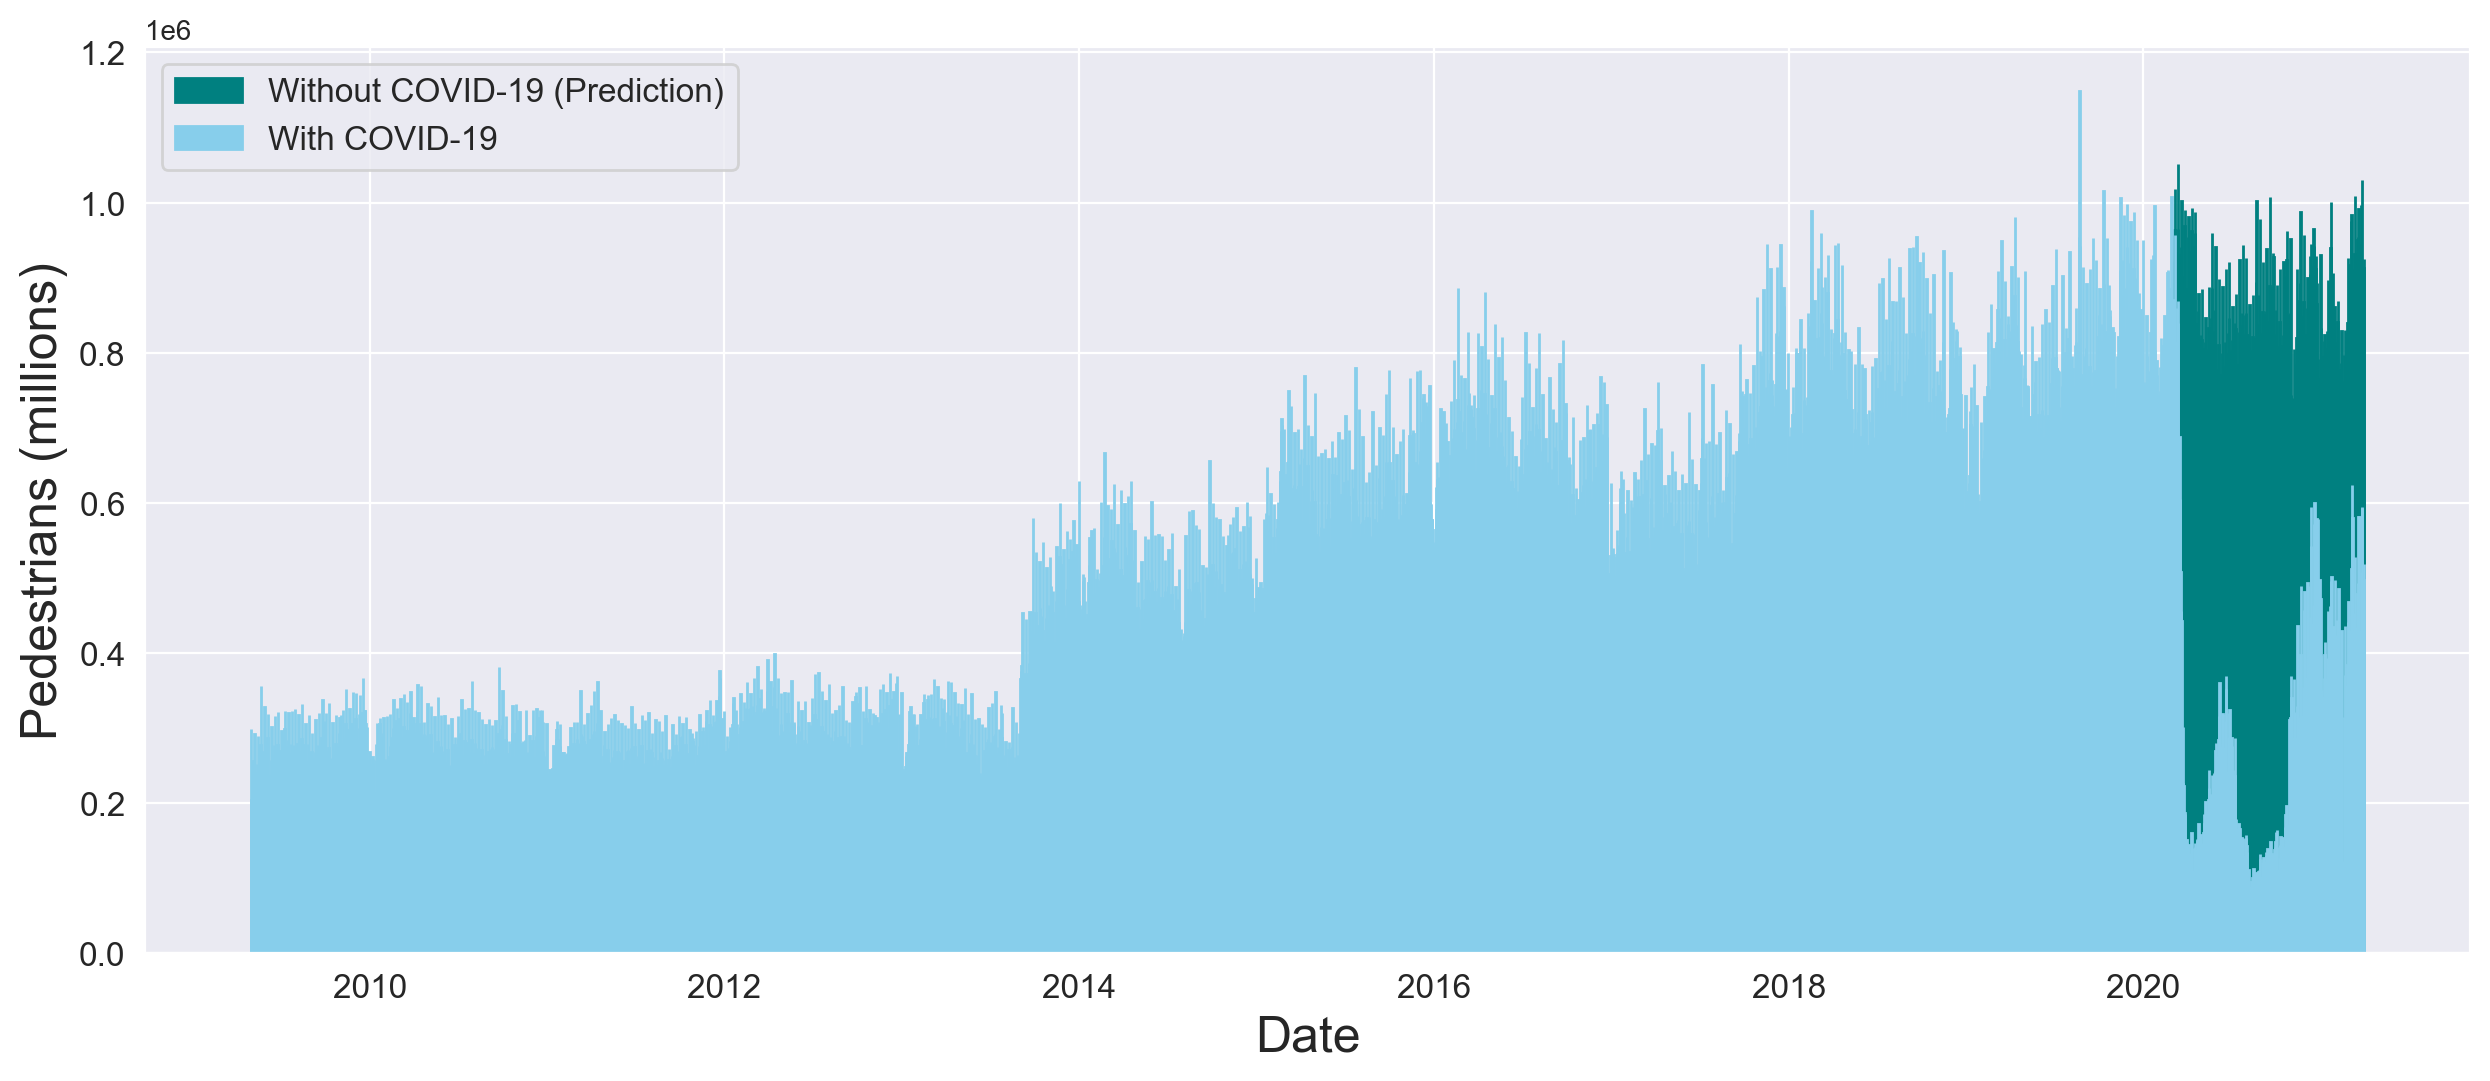

In [32]:
fig,ax = plt.subplots(figsize=(15, 6), dpi=200)
org=plt.bar(result_count['Date_time_date'],result_count['Y_new'],edgecolor='teal',color='teal',label='With COVID-19')
cov=plt.bar(result_count['Date_time_date'],result_count['Hourly_Counts'],edgecolor='skyblue',color='skyblue',label='Without COVID-19')

plt.ylabel('Pedestrians (millions)',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.xticks(size=12)
plt.yticks(size=12)
plt.legend([org, cov],['Without COVID-19 (Prediction)','With COVID-19'],loc=2,prop={'size': 12})
plt.show()

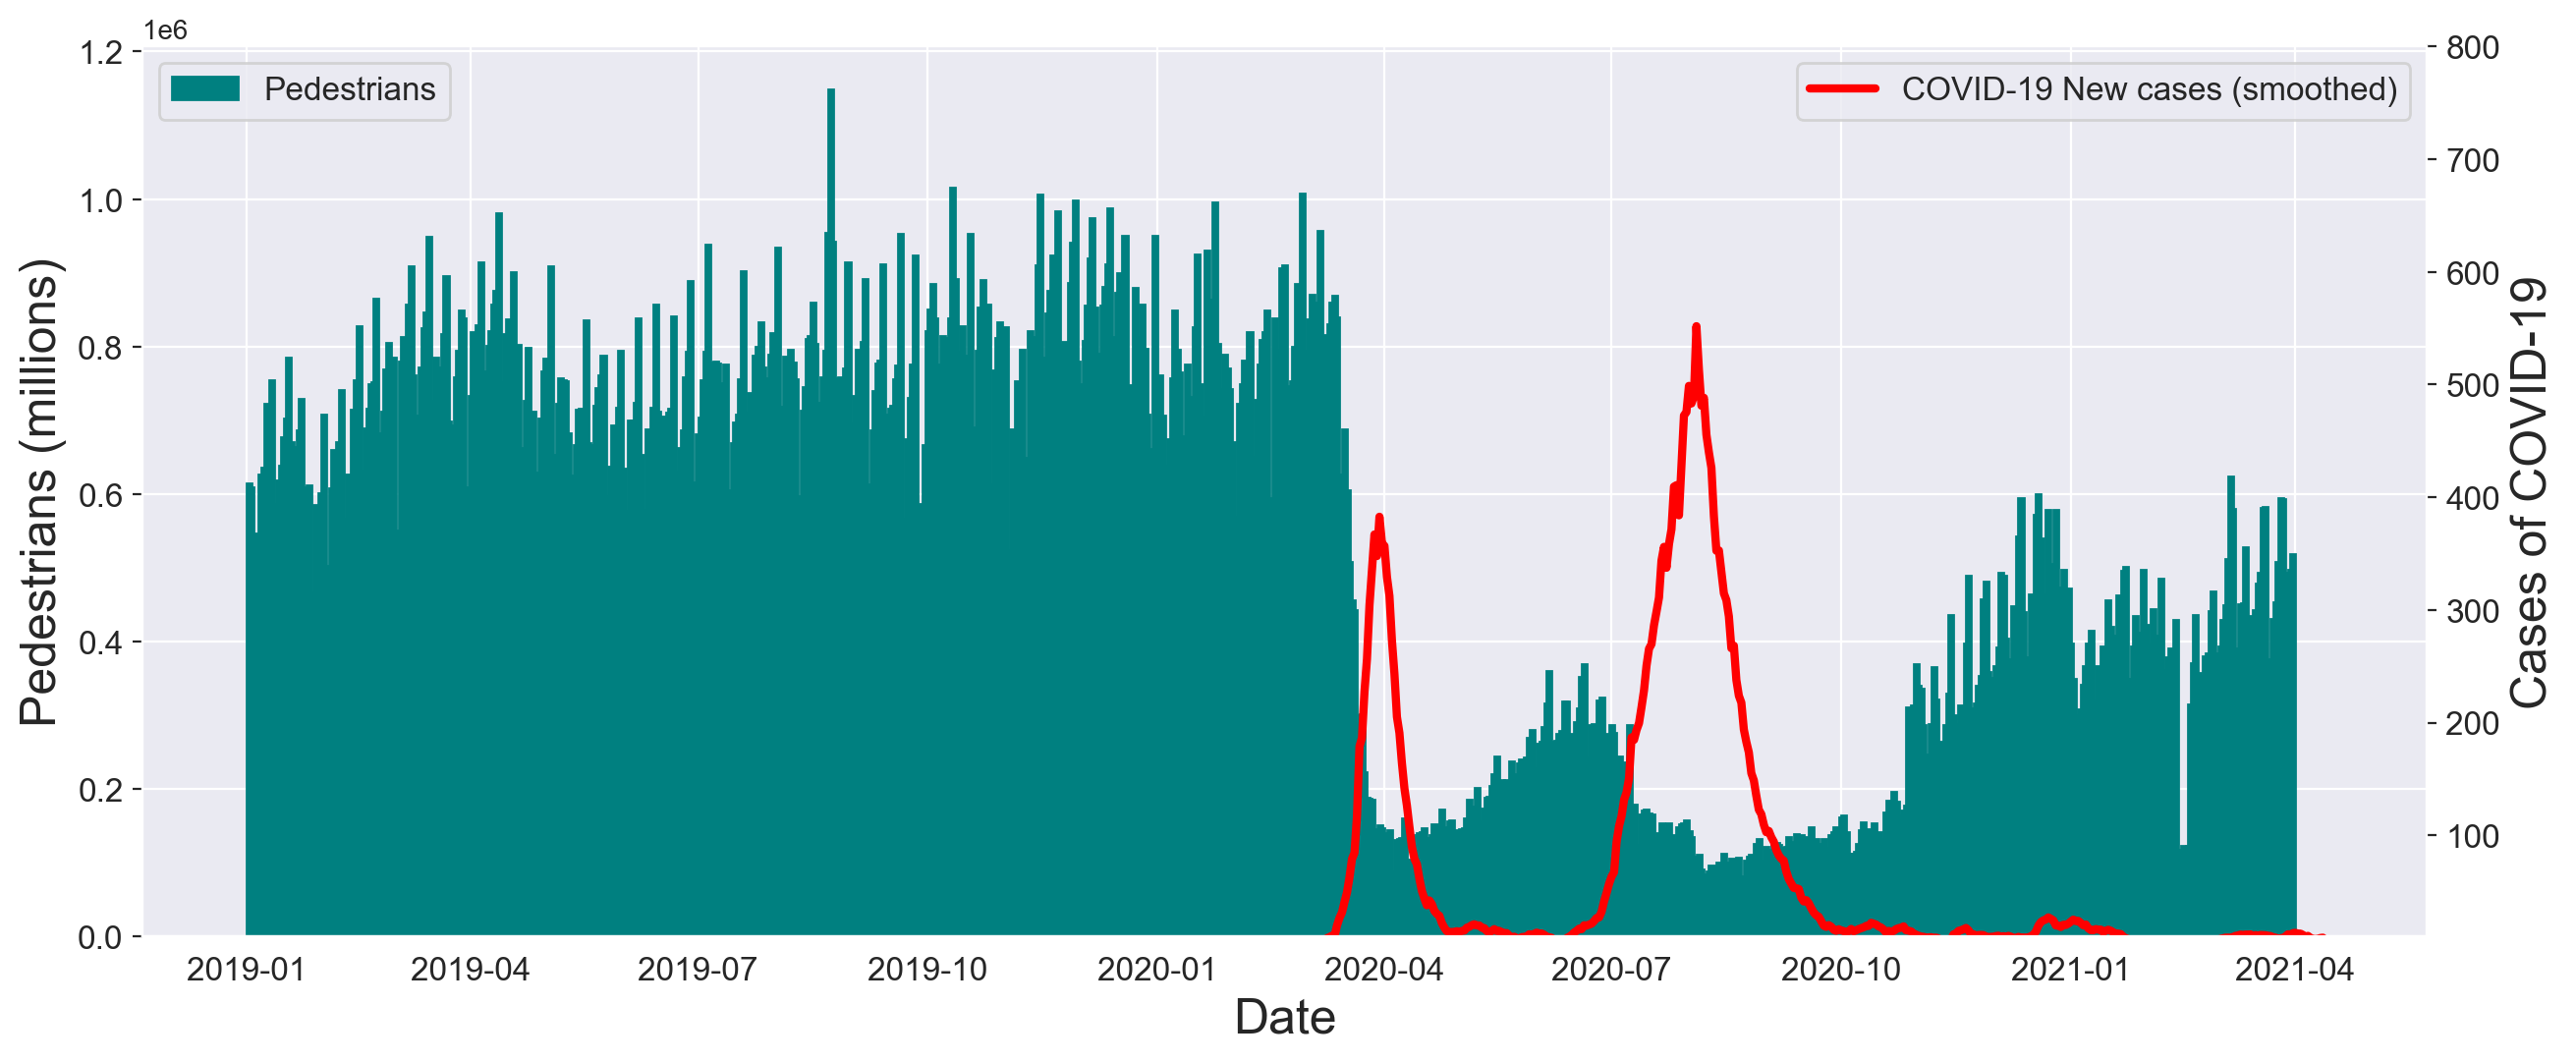

In [33]:
fig,ax = plt.subplots(figsize=(15, 6), dpi=200)
sns.set_style('darkgrid')

result_count_AC=result_count.loc[result_count['Date_time_date']>datetime(year= 2019,month=1,day=1).date()]

ped=ax.bar(result_count_AC['Date_time_date'],
            result_count_AC['Hourly_Counts'],edgecolor='teal',color='teal',label='Pedestrians',width=2)

plt.ylabel('Pedestrians (millions)',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.xticks(size=12)
plt.yticks(size=12)
plt.legend(loc=2,prop={'size': 12})

ax2=ax.twinx()
ax2.set_ylabel('Cases of COVID-19',fontsize=18)
ax2.grid(False)
ax2.set_ylim([10,800])
#ax2.set_yticks(size=12)
ax2.tick_params(axis='y', labelsize=12)
ax2=plt.plot(covid_data['Date_Time'],covid_data['new_cases_smoothed'],color='red',linewidth=3,label='COVID-19 New cases (smoothed)')
plt.legend(loc=1,prop={'size': 12})

plt.show()

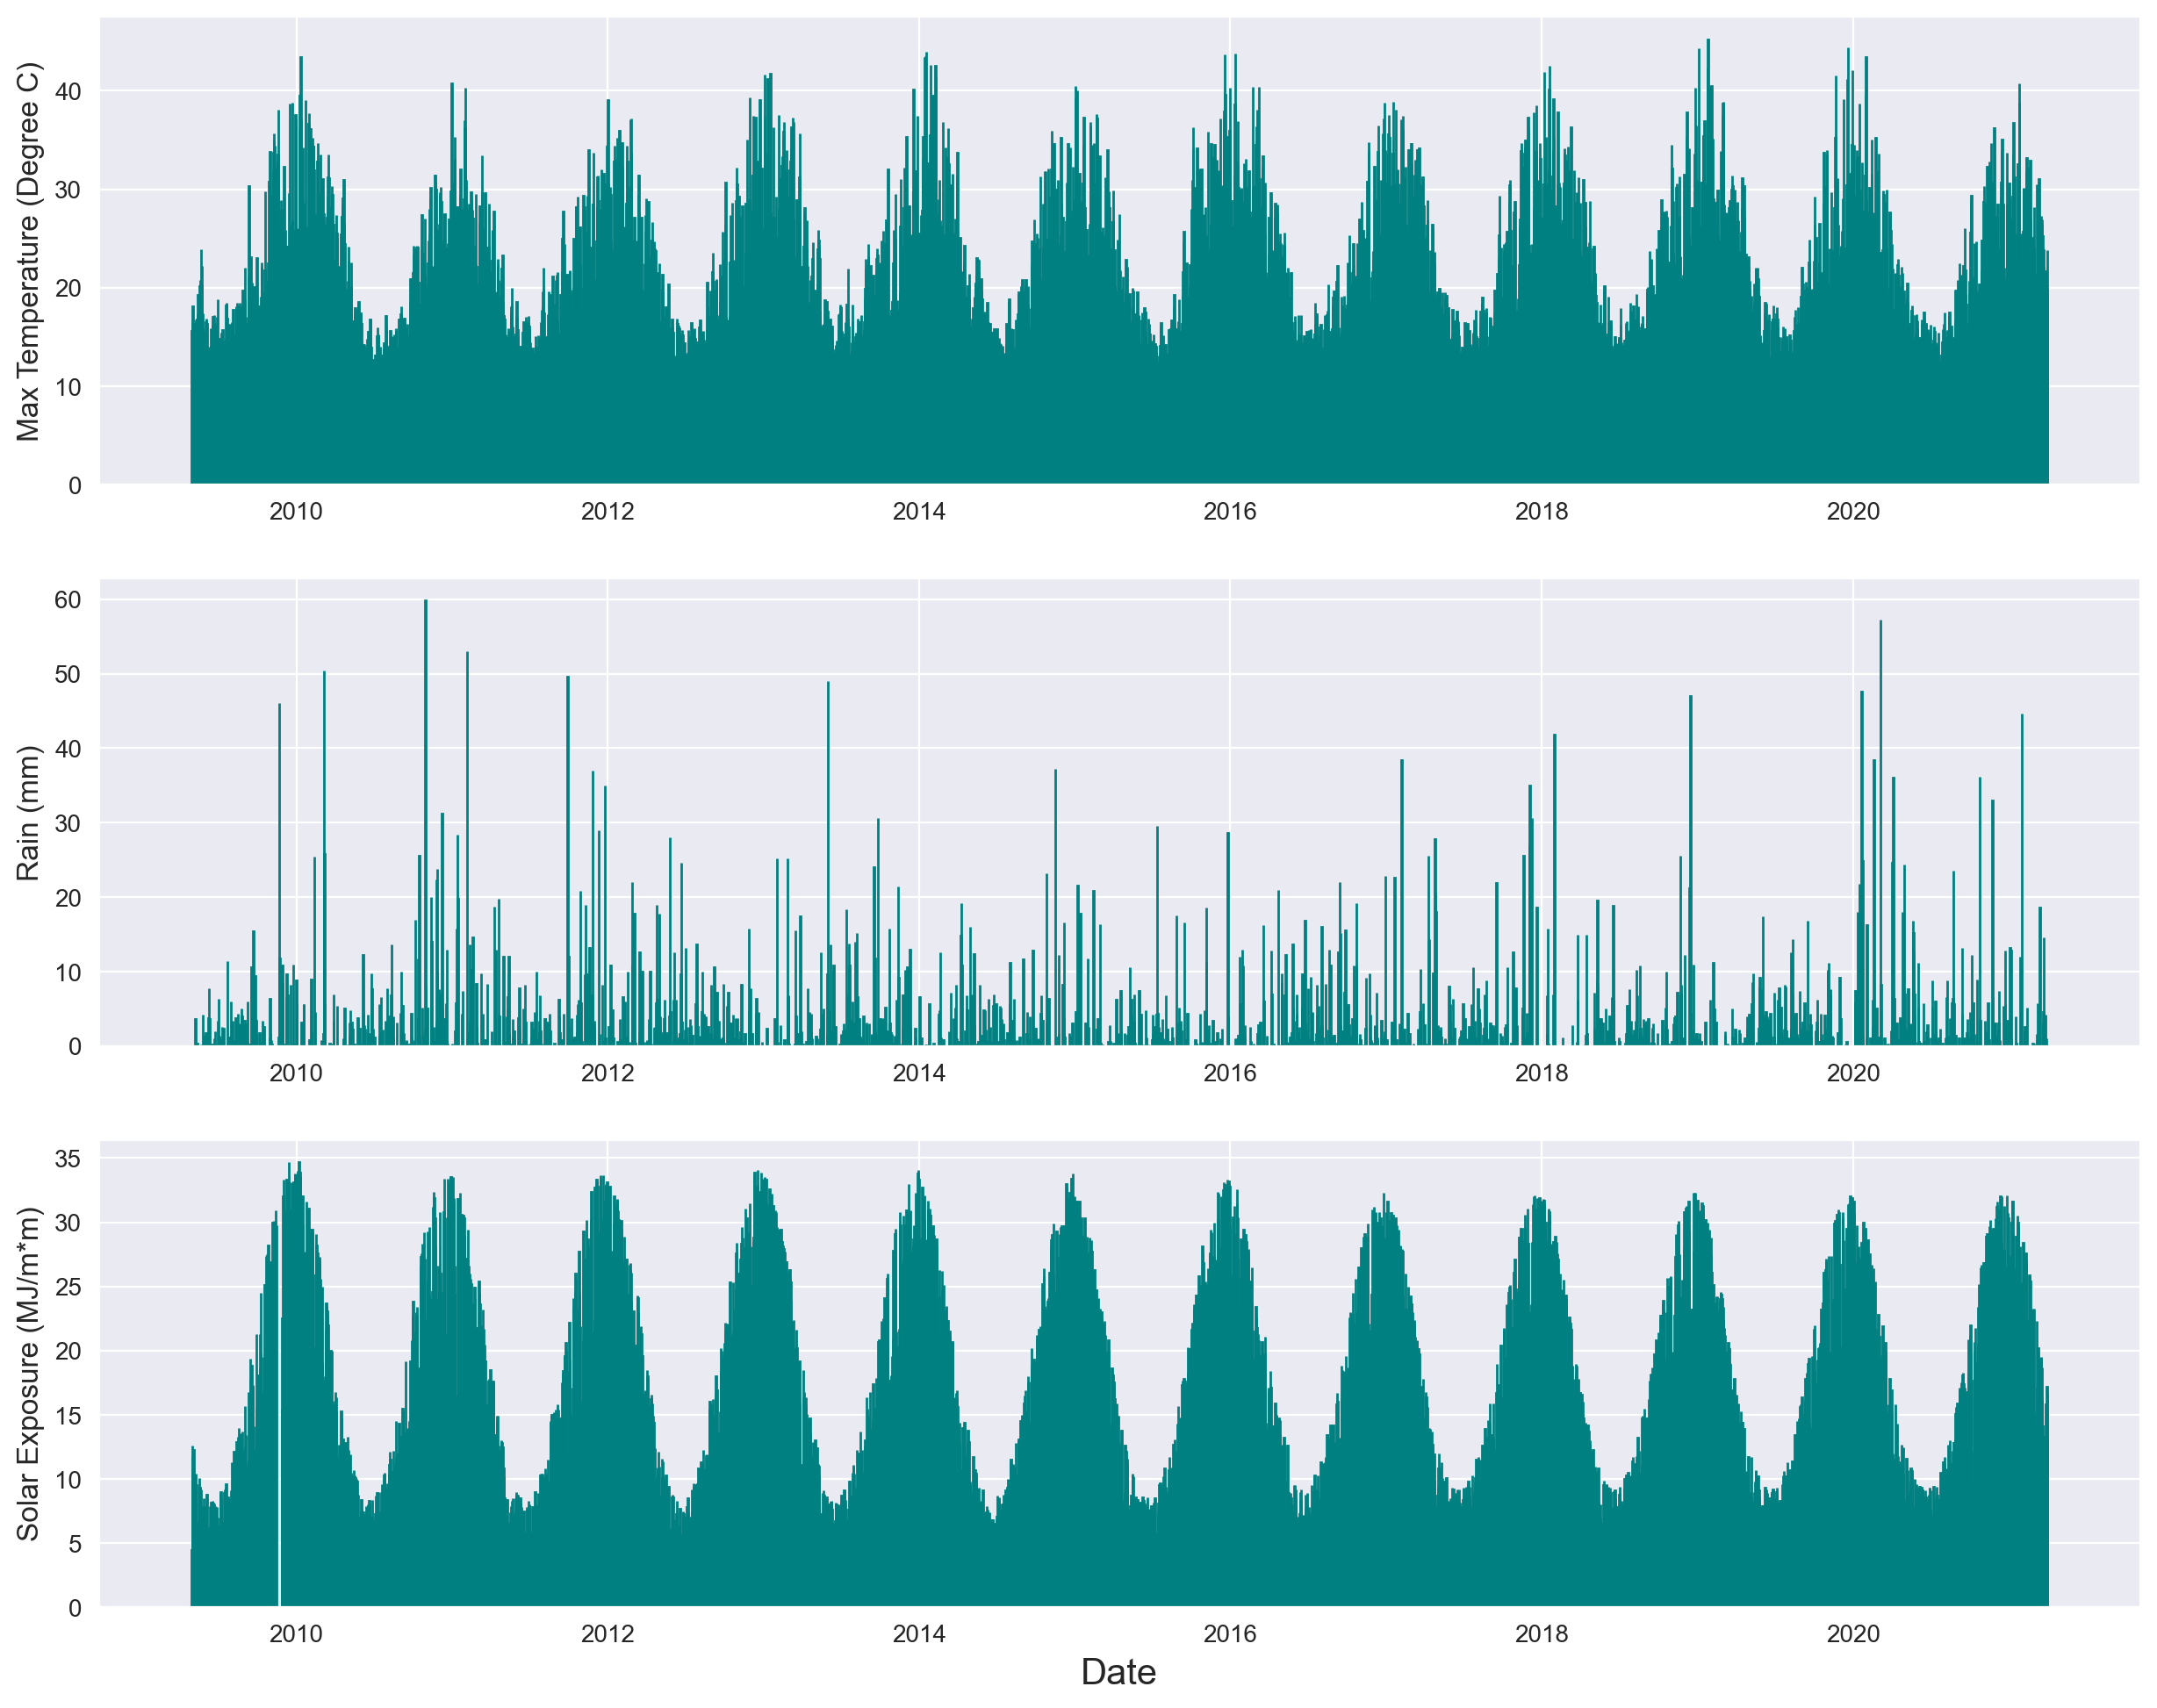

In [17]:
fig, [ax1,ax2,ax3] = plt.subplots(3,figsize=(15, 12), dpi=200)  
ax1.bar(weather_df['Date_Time'],weather_df['Maximum temperature (Degree C)'],edgecolor='teal',color='teal')
ax1.set_ylabel('Max Temperature (Degree C)',fontsize=12)

ax2.bar(weather_df['Date_Time'],weather_df['rain (mm)'],edgecolor='teal',color='teal')
ax2.set_ylabel('Rain (mm)',fontsize=12)

ax3.bar(weather_df['Date_Time'],weather_df['Daily global solar exposure (MJ/m*m)'],edgecolor='teal',color='teal')
ax3.set_ylabel('Solar Exposure (MJ/m*m)',fontsize=12)

plt.xlabel('Date',fontsize=15)

plt.show()

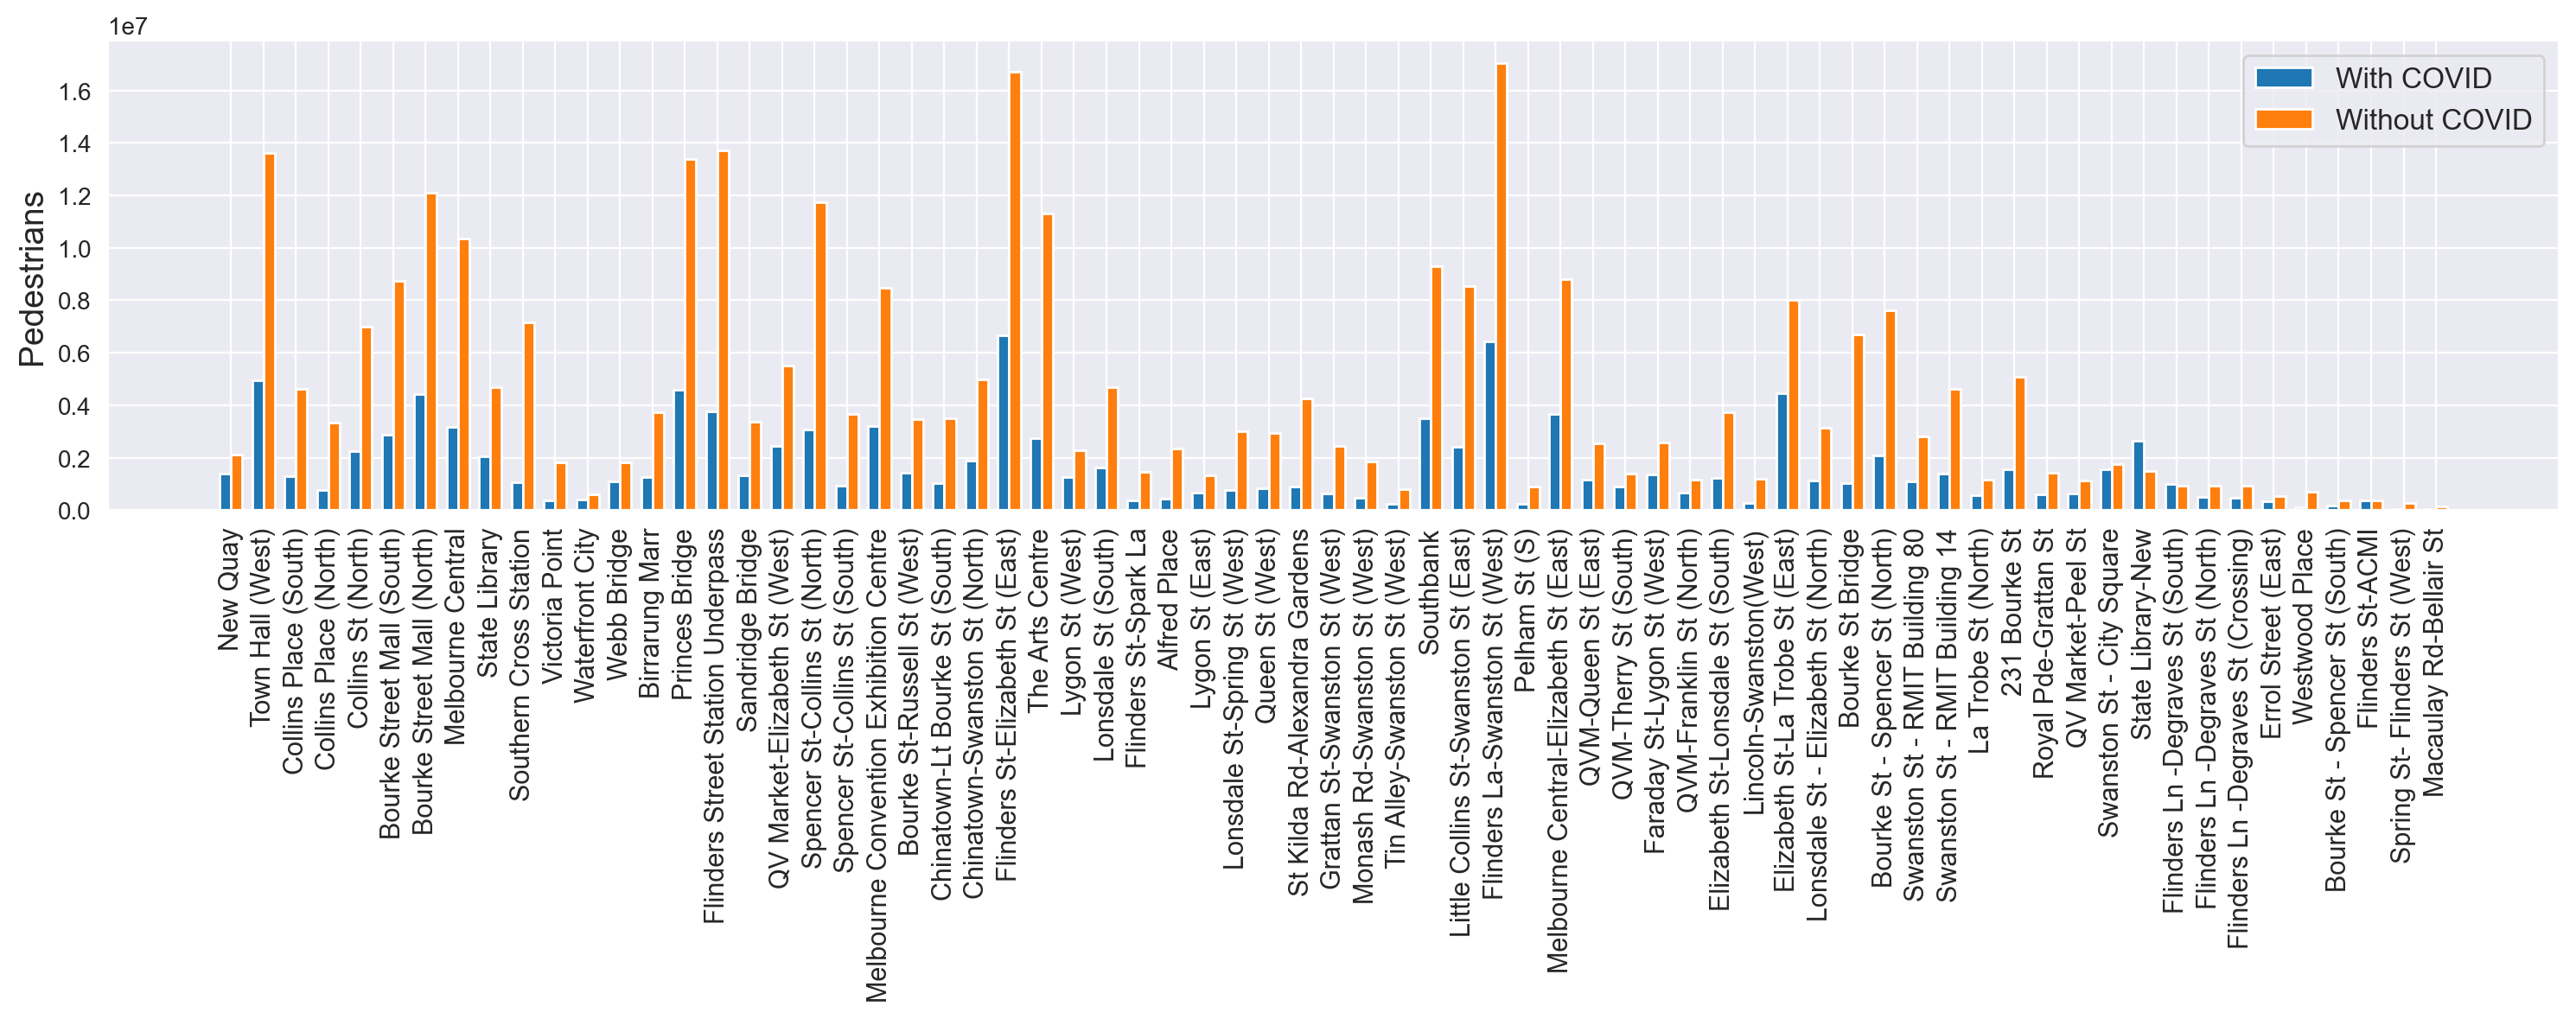

In [15]:
results_AC=result.loc[result['Date_time_date']>datetime(year= 2020,month=3,day=1).date()]

sensors = results_AC['Sensor_Name'].unique()

sensor_count_REAL = {}
for sensor in sensors:
    sensor_count_REAL[sensor]=results_AC.loc[results_AC['Sensor_Name']==sensor]['Hourly_Counts'].sum()

sensor_count_PED = {}
for sensor in sensors:
    sensor_count_PED[sensor]=results_AC.loc[results_AC['Sensor_Name']==sensor]['Y_new'].sum()

    
y_REAL=list(sensor_count_REAL.values())
x_REAL=list(sensor_count_REAL.keys())

y_PED=list(sensor_count_PED.values())
x_PED=list(sensor_count_PED.keys())


x = np.arange(len(x_PED))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 6), dpi=200)
rects1 = ax.bar(x - width/2, y_REAL, width, label='With COVID')
rects2 = ax.bar(x + width/2, y_PED, width, label='Without COVID')

ax.set_ylabel('Pedestrians',fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(x_PED,rotation=90,fontsize=11)
ax.legend(loc=1,prop={'size': 12})


fig.tight_layout()

plt.show()

# Discussion

To futher improve our predictions we could tune the hypeparameters of the random forrest model, but since the random forrest algorithem does not need much tunning and the data set is very large, it would not make sence for futher improvements of the model. 

# Contributions

The overall contributions can be seen on the website in the tab "other".